In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import graphviz
from graphviz import Graph

import env
import wrangle_zillow
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# change display settings to show all columns
pd.set_option("display.max_columns", None)

In [3]:
# use a function to pull in, clean, split, and scale the zillow data
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow.prep_zillow_data()
train.head(2)

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,landusecode,regionidcounty,regionidzip,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,landusedesc,age,los_angeles,orange,ventura
23907,2.0,3,1690,orange,33872532,-117890055,11100,122,1286,97039,118231,279973,2016,161742,3303,-0.055371,2017-04-06,Single Family Residential,64,0,1,0
54621,2.0,4,1445,orange,33868950,-117806403,6300,122,1286,97026,88862,381765,2016,292903,4494,0.030305,2017-07-07,Single Family Residential,50,0,1,0


In [4]:
train.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,bathrooms,bedrooms,area,latitude,longitude,lot_area,structuretaxvalue,taxvalue,landtaxvalue,taxamount,logerror,age,los_angeles,orange,ventura
count,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847
mean,2.05783,2.98112,1545.19,3.3988e+07,-1.18168e+08,6660.88,131894,343912,212054,4250.82,0.00380957,52.6697,0.554715,0.343019,0.102266
std,0.673162,0.8719,526.326,275983,383374,2404.94,74383.4,196317,156761,2257.75,0.0421077,21.8841,0.497007,0.474727,0.303004
min,1,1,501,3.33395e+07,-1.19448e+08,236,44,3254,1627,49,-0.111444,4,0,0,0
25%,2,2,1158,3.37864e+07,-1.18375e+08,5616.5,75228,188462,75790.5,2511.5,-0.0208791,36,0,0,0
50%,2,3,1452,3.39552e+07,-1.18105e+08,6100,118073,327766,187917,4037,0.00426836,55,1,0,0
75%,2.5,4,1850,3.41801e+07,-1.17886e+08,7513.5,175883,472786,314106,5722.5,0.0283306,67,1,1,0
max,4,6,3236,3.47184e+07,-1.17555e+08,16020,364196,951279,686939,10680,0.123189,113,1,1,1


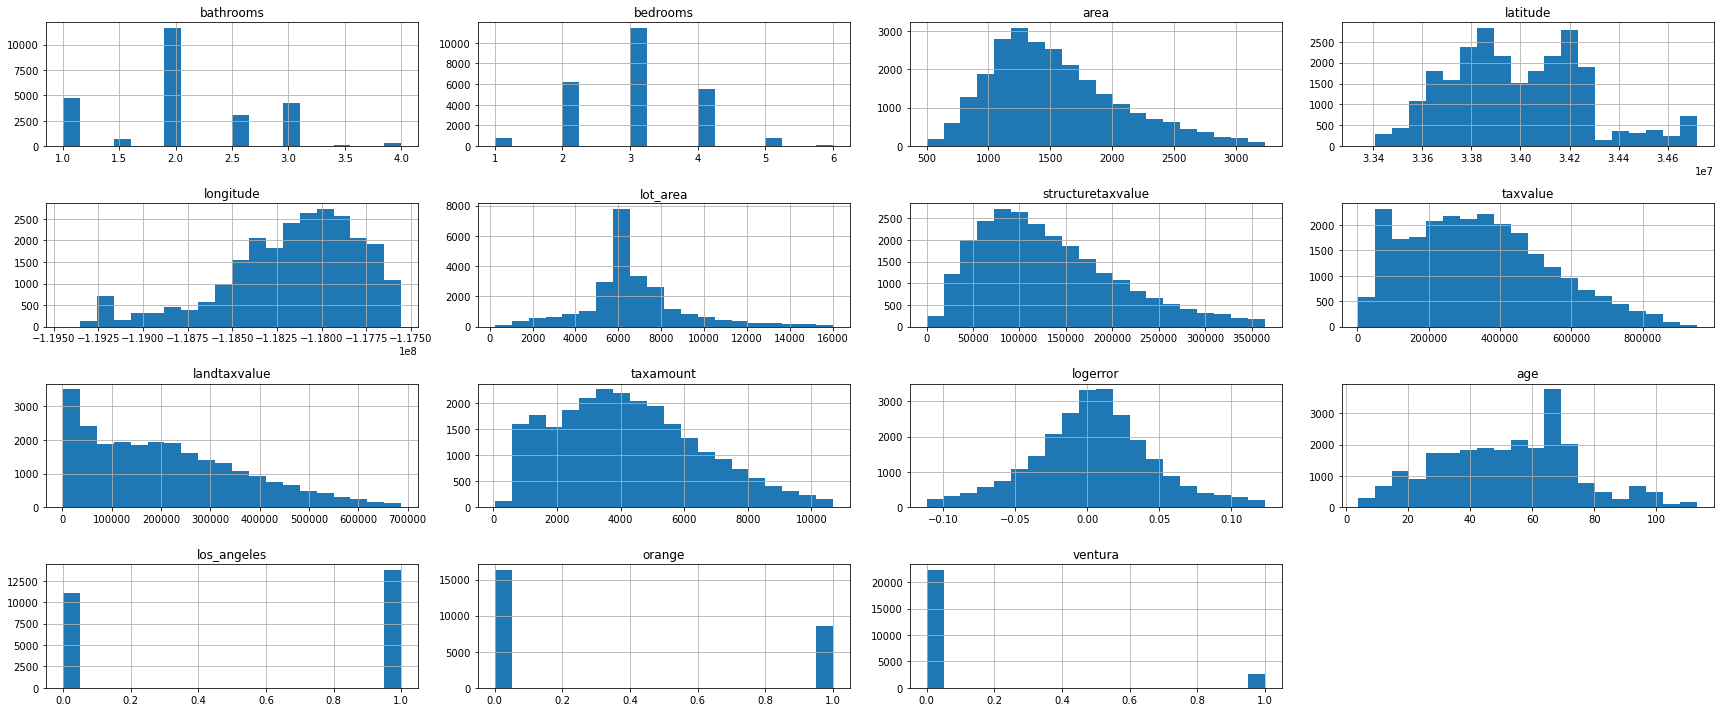

In [5]:
# check distribution of numerical columns
train.hist(figsize=(24, 10), bins=20)
plt.tight_layout()

In [7]:
train[['counties','landusedesc']].value_counts()

counties     landusedesc                               
los_angeles  Single Family Residential                     12572
orange       Single Family Residential                      5414
             Condominium                                    3109
ventura      Single Family Residential                      1686
los_angeles  Condominium                                    1207
ventura      Condominium                                     684
             Cluster Home                                    162
             Manufactured, Modular, Prefabricated Homes        9
los_angeles  Mobile Home                                       3
             Townhouse                                         1
dtype: int64

**Takeaways**

**Logerror is normally distributed**

**None of the features seem to have extreme outliers although many are skewed to the right**